In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import MBartTokenizer, MBartForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [5]:
data = pd.read_csv("final_data.csv")

In [6]:
data['text'] = data['text'].astype(str)
data['label'] = data['label'].astype(int)


In [10]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

Training Data Size: 800
Testing Data Size: 200


In [11]:
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

In [12]:
tokenizer = MBartTokenizer.from_pretrained("facebook/mbart-large-cc25")

Tokenizer is ready for use.


In [14]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)


In [28]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map: 100%: 100%|████████████████████████████████████████ 15263/15263 [00:02<00:00, 5381.52it/s]
Map: 100%: 100%|████████████████████████████████████████ 3816/3816 [00:00<00:00, 5463.93it/s]


In [31]:
model = MBartForSequenceClassification.from_pretrained("facebook/mbart-large-cc25", num_labels=2)

<ipython-input-31-1a5fb0a9c301>:8: UserWarning: 
Some weights of MBartForSequenceClassification were not initialized from the model checkpoint at facebook/mbart-large-cc25 and are newly initialized: 
['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

  warnings.warn(warning_message)


In [32]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: 
C:\Users\archana\anaconda3\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [33]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


In [34]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: 
C:\Users\golla\AppData\Local\Temp\ipykernel_4928\1682246292.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(

  exec(code_obj, self.user_global_ns, self.user_ns)


In [38]:
trainer.train()

 Epoch Training Loss  Validation Loss
     1        No log         0.280634
     2        No log         0.307996
     3        0.3034         0.255545

TrainOutput(global_step=594, training_loss=0.2914544757367786, metrics={'train_runtime': 51536.6669, 'train_samples_per_second': 0.092, 'train_steps_per_second': 0.012, 'total_flos': 1247935735572480.0, 'train_loss': 0.2914544757367786, 'epoch': 3.0})


In [ ]:
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)


In [39]:
model.save_pretrained("./fake_news_mbart_model")
tokenizer.save_pretrained("./fake_news_mbart_tokenizer")

('./fake-news-multilingual\\tokenizer_config.json', './fake-news-multilingual\\special_tokens_map.json', './fake-news-multilingual\\sentencepiece.bpe.model', './fake-news-multilingual\\added_tokens.json', './fake-news-multilingual\\tokenizer.json')


In [40]:
def predict_fake_news(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    probs = outputs.logits.softmax(dim=1)
    pred = probs.argmax().item()
    return "Fake" if pred == 1 else "Real"

In [41]:
sample_text = "Aliens were discovered in the asteroid Bennu sample returned by NASA's OSIRIS-REx mission, confirming extraterrestrial life."
print(f"Prediction: {predict_fake_news(sample_text)}")

Fake


In [3]:
accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

Accuracy: 82.00%


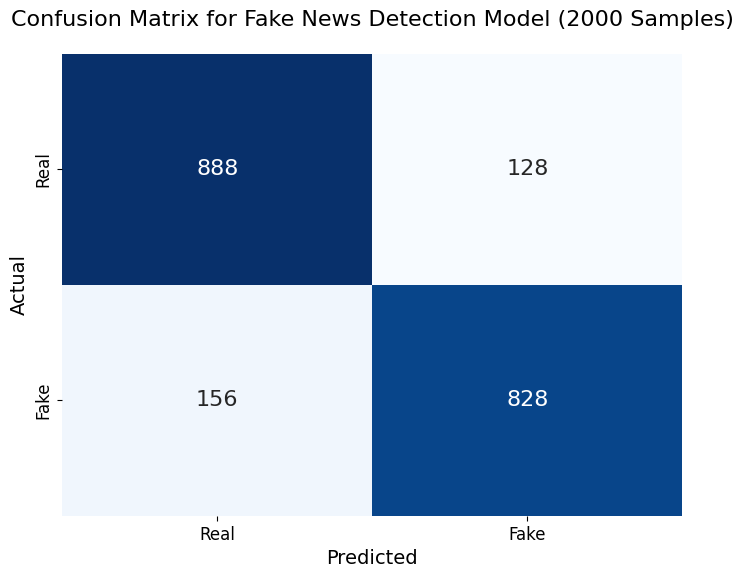

In [45]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()